Mind-small dataset

Mjölnir Software Alchemists

In [1]:
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import matplotlib.dates as mdates
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
#path to the mindsmall training data
training_dataset = '../MINDsmall_train'

validation_dataset = '../MINDsmall_train'

# not sure how to read these ones with header calues yet, as they are .vec files, and not .csv files
entity_embedding = pd.read_csv("../MINDsmall_train/entity_embedding.vec", sep='\t')
relation_embedding = pd.read_csv("../MINDsmall_train/relation_embedding.vec", sep='\t')


news_data = pd.read_csv("../MINDsmall_train/news.tsv",
    sep='\t',
    names=["newsId", "category", "subcategory", "title","abstract", "url", "title_entities","abstract_entities"]
)

# behaviors_data = pd.read_csv(
#     "MINDsmall_train/behaviors.tsv",
#     sep='\t',
#     names=["impressionId","userId","timestamp","click_history","impressions"]
# )
behaviors_data = pd.read_csv(
    "../MINDsmall_train/behaviors.tsv",
    sep='\t',
    names=["impressionId", "userId", "timestamp", "click_history", "impressions"],
    parse_dates=['timestamp'] # This line parses the 'timestamp' column into datetime objects
)

In [3]:
behaviors_data['timestamp'] = pd.to_datetime(behaviors_data['timestamp'], format='%Y-%m-%d %H:%M:%S')
behaviors_data['clicks'] = behaviors_data['click_history'].str.split().str.len()
behaviors_data['impressions_list'] = behaviors_data['impressions'].str.split()
behaviors_data['impressions_count'] = behaviors_data['impressions_list'].str.len()

In [4]:
behaviors_data['clicks'].describe()

count    153727.000000
mean         33.225387
std          40.408679
min           1.000000
25%           8.000000
50%          20.000000
75%          43.000000
max         558.000000
Name: clicks, dtype: float64

In [5]:
behaviors_data.head()

,impressionId,userId,timestamp,click_history,impressions,clicks,impressions_list,impressions_count
0,1,U13740,2019-11-11 09:05:58,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0,9.0,"[N55689-1, N35729-0]",2
1,2,U91836,2019-11-12 18:11:30,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...,82.0,"[N20678-0, N39317-0, N58114-0, N20495-0, N4297...",11
2,3,U73700,2019-11-14 07:01:48,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...,16.0,"[N50014-0, N23877-0, N35389-0, N49712-0, N1684...",36
3,4,U34670,2019-11-11 05:28:05,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0,10.0,"[N35729-0, N33632-0, N49685-1, N27581-0]",4
4,5,U8125,2019-11-12 16:11:21,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...,4.0,"[N39985-0, N36050-0, N16096-0, N8400-1, N22407...",69


In [6]:
news_data.head()

,newsId,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


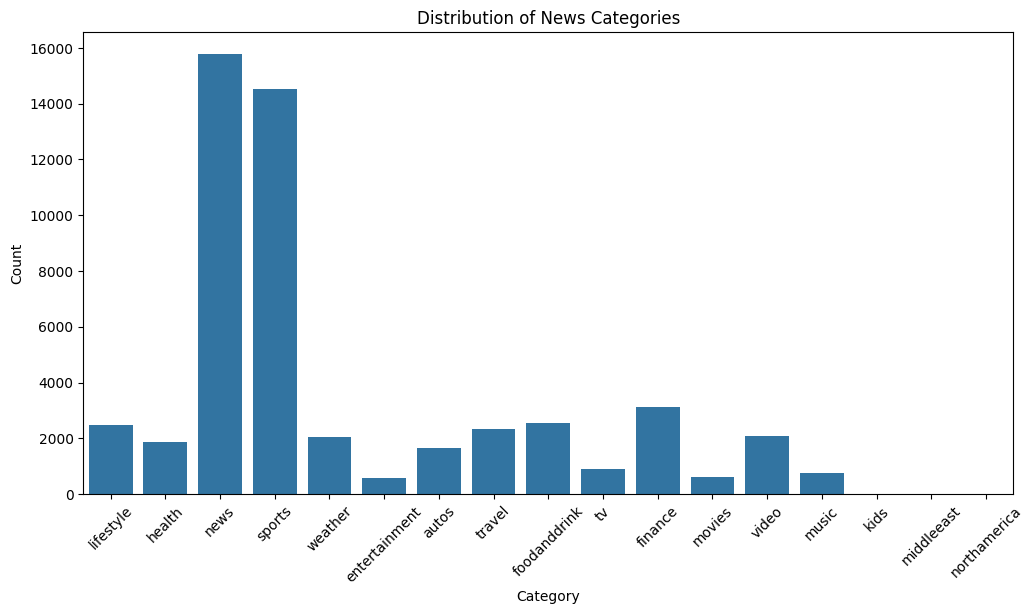

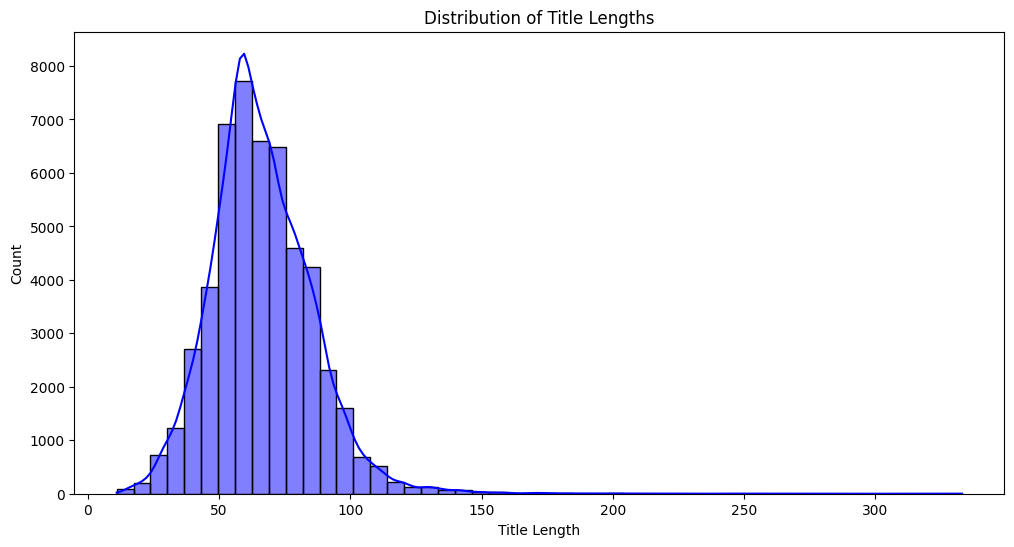

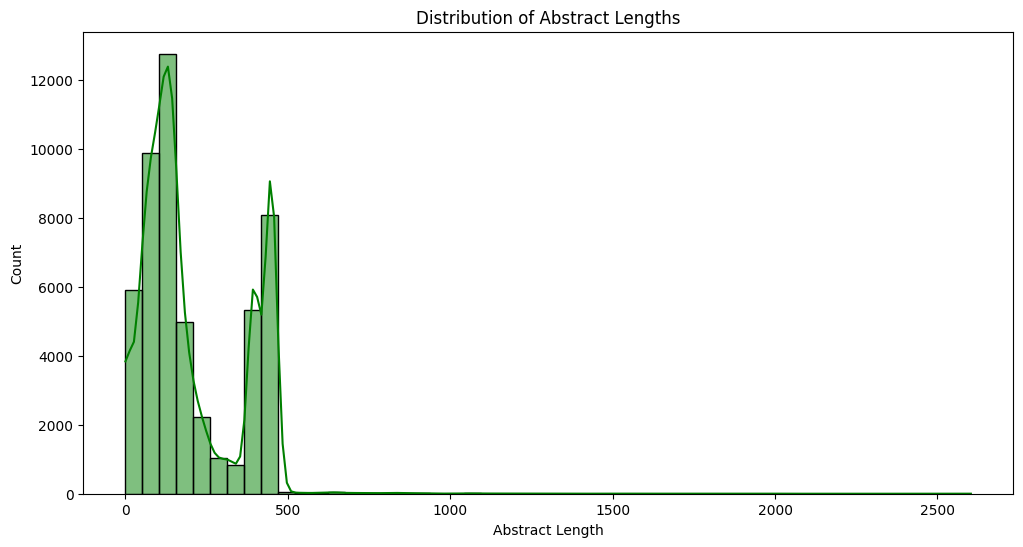

In [7]:
# Distribution of News Categories
plt.figure(figsize=(12, 6))
sns.countplot(x='category', data=news_data)
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Analyze title and abstract lengths
news_data['title_length'] = news_data['title'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
news_data['abstract_length'] = news_data['abstract'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

plt.figure(figsize=(12, 6))
sns.histplot(news_data['title_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Title Lengths')
plt.xlabel('Title Length')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(news_data['abstract_length'], bins=50, kde=True, color='green')
plt.title('Distribution of Abstract Lengths')
plt.xlabel('Abstract Length')
plt.ylabel('Count')
plt.show()

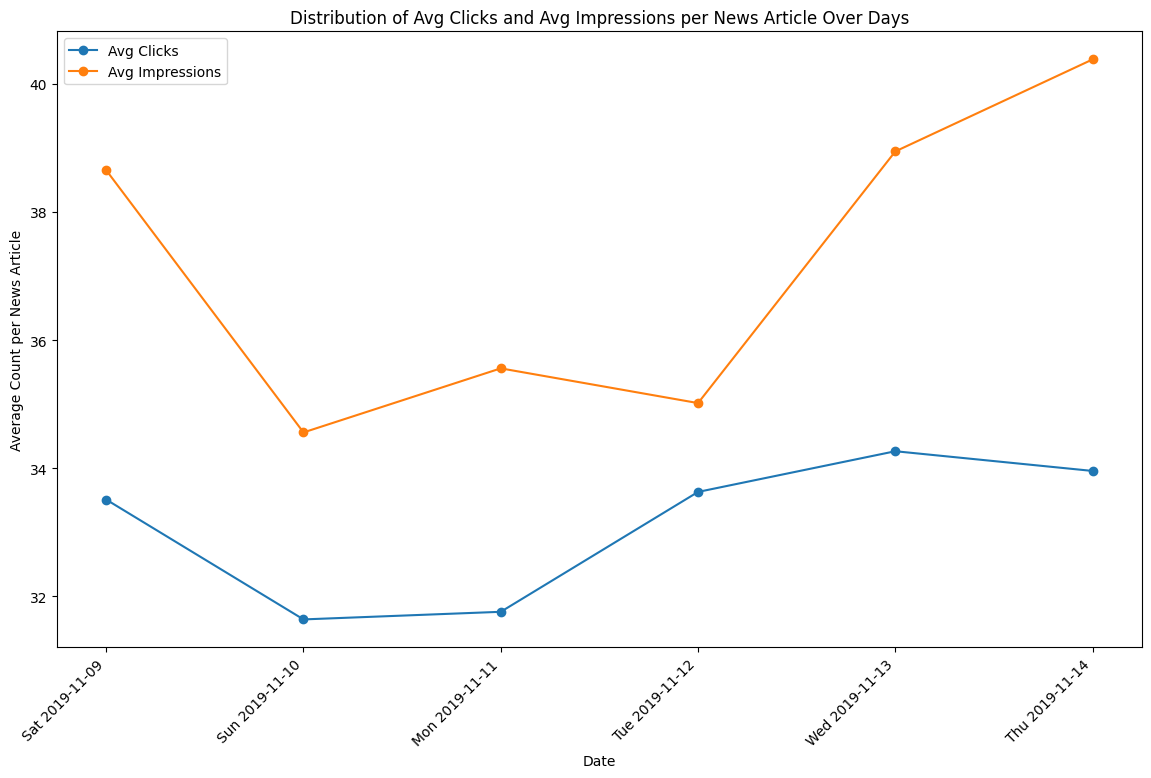

In [8]:
# Ensure that 'timestamp' column is in datetime format
behaviors_data['timestamp'] = pd.to_datetime(behaviors_data['timestamp'], format='%Y-%m-%d %H:%M:%S')

# Calculate average clicks and impressions per news article for each day
daily_avg_clicks = behaviors_data.groupby(behaviors_data['timestamp'].dt.date)['clicks'].mean()
daily_avg_impressions = behaviors_data.groupby(behaviors_data['timestamp'].dt.date)['impressions_count'].mean()

# Distribution of Average Clicks and Impressions per news article over days
plt.figure(figsize=(14, 8))

plt.plot(daily_avg_clicks.index, daily_avg_clicks.values, label='Avg Clicks', marker='o')
plt.plot(daily_avg_impressions.index, daily_avg_impressions.values, label='Avg Impressions', marker='o')

plt.title('Distribution of Avg Clicks and Avg Impressions per News Article Over Days')
plt.xlabel('Date')
plt.ylabel('Average Count per News Article')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add both weekdays and dates below the x-axis
date_labels = [date.strftime('%a %Y-%m-%d') for date in daily_avg_clicks.index]
plt.xticks(daily_avg_clicks.index, labels=date_labels, rotation=45, ha='right')

plt.show()

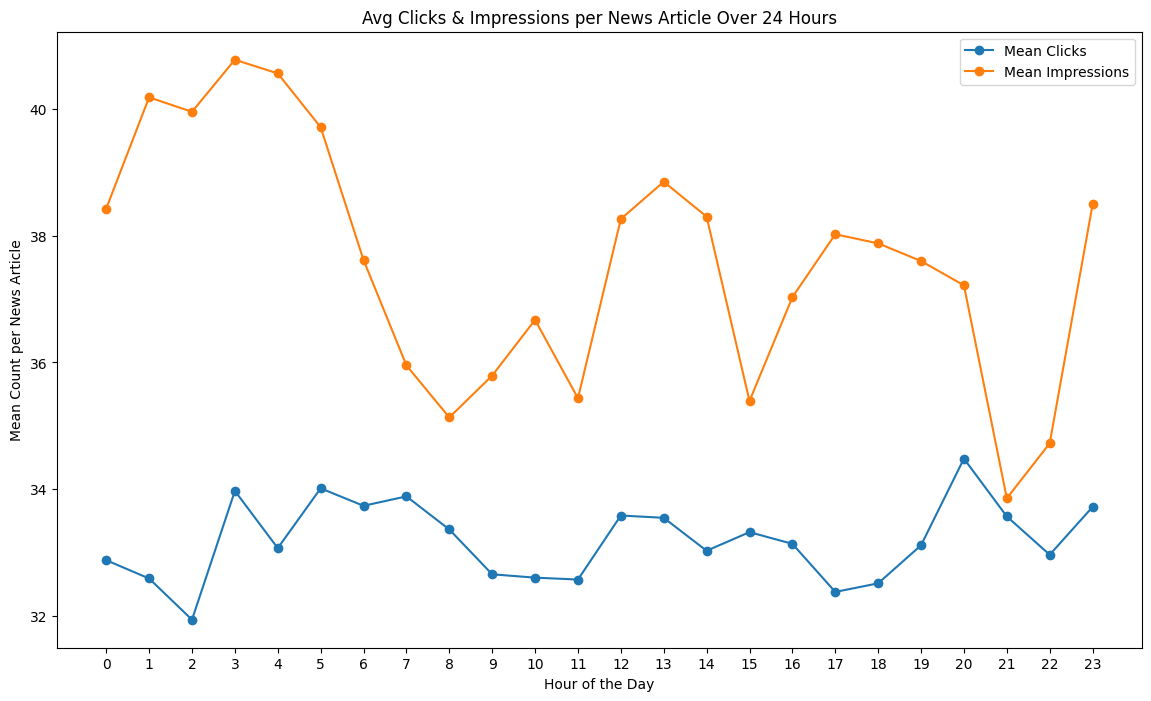

In [9]:
# Ensure that 'timestamp' column is in datetime format
behaviors_data['timestamp'] = pd.to_datetime(behaviors_data['timestamp'], format='%Y-%m-%d %H:%M:%S')

# Calculate mean clicks and impressions per news article for each hour
hourly_mean_clicks = behaviors_data.groupby(behaviors_data['timestamp'].dt.hour)['clicks'].mean()
hourly_mean_impressions = behaviors_data.groupby(behaviors_data['timestamp'].dt.hour)['impressions_count'].mean()

# Distribution of Mean Clicks and Impressions per news article over 24 hours
plt.figure(figsize=(14, 8))

plt.plot(hourly_mean_clicks.index, hourly_mean_clicks.values, label='Mean Clicks', marker='o')
plt.plot(hourly_mean_impressions.index, hourly_mean_impressions.values, label='Mean Impressions', marker='o')

plt.title('Avg Clicks & Impressions per News Article Over 24 Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Count per News Article')
plt.legend()
plt.xticks(range(24))  # X-axis ticks for each hour
plt.show()

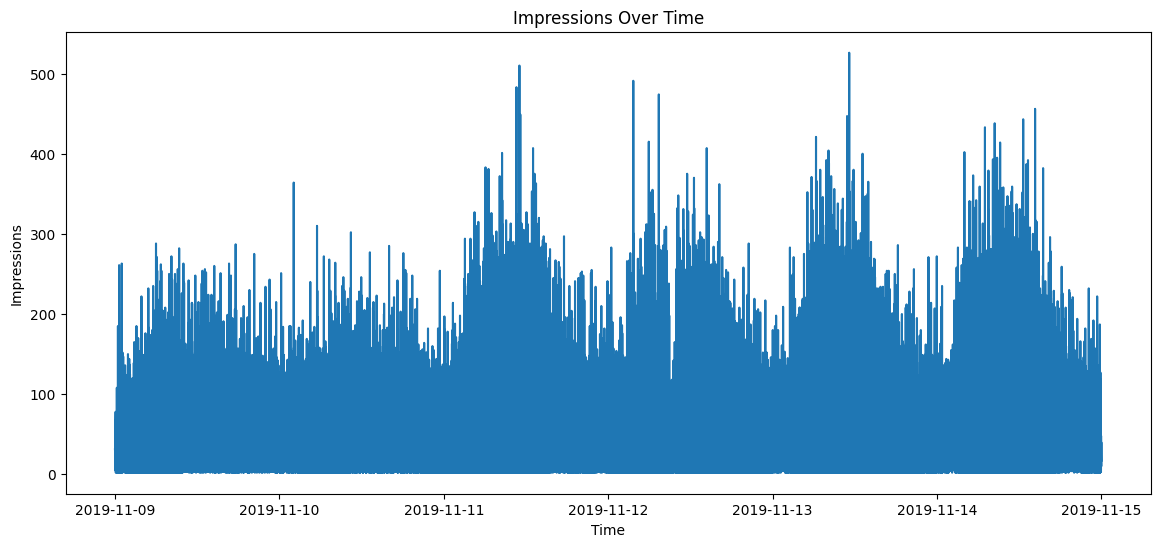

In [10]:
# User behavior over time
plt.figure(figsize=(14, 6))
impressions_over_time = behaviors_data.groupby('timestamp')['impressions_count'].sum().reset_index()
plt.plot(impressions_over_time['timestamp'], impressions_over_time['impressions_count'])
plt.title('Impressions Over Time')
plt.xlabel('Time')
plt.ylabel('Impressions')
plt.show()

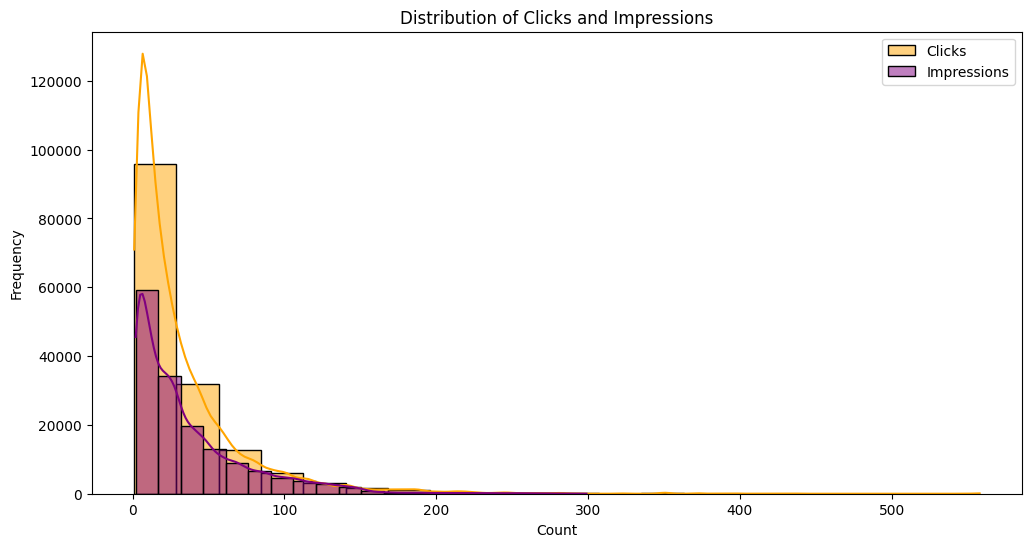

In [11]:
# Distribution of Clicks and Impressions
plt.figure(figsize=(12, 6))
sns.histplot(behaviors_data['clicks'], bins=20, kde=True, color='orange', label='Clicks')
sns.histplot(behaviors_data['impressions_count'], bins=20, kde=True, color='purple', label='Impressions')
plt.title('Distribution of Clicks and Impressions')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()




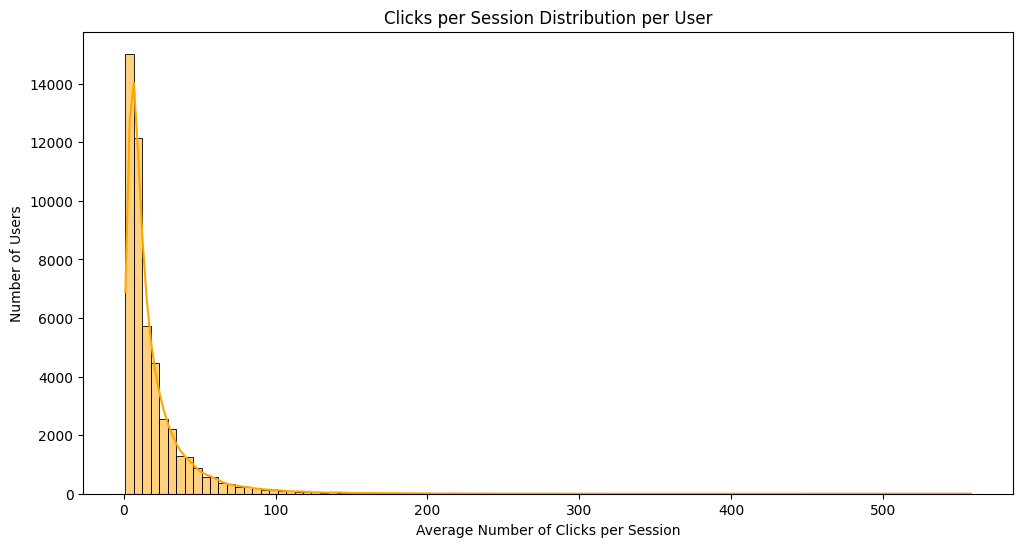

In [12]:
user_session_lengths = behaviors_data.groupby('userId')['clicks'].mean()
plt.figure(figsize=(12, 6))
sns.histplot(user_session_lengths, bins=100, kde=True, color='orange')
plt.title('Clicks per Session Distribution per User')
plt.xlabel('Average Number of Clicks per Session')
plt.ylabel('Number of Users')
plt.show()


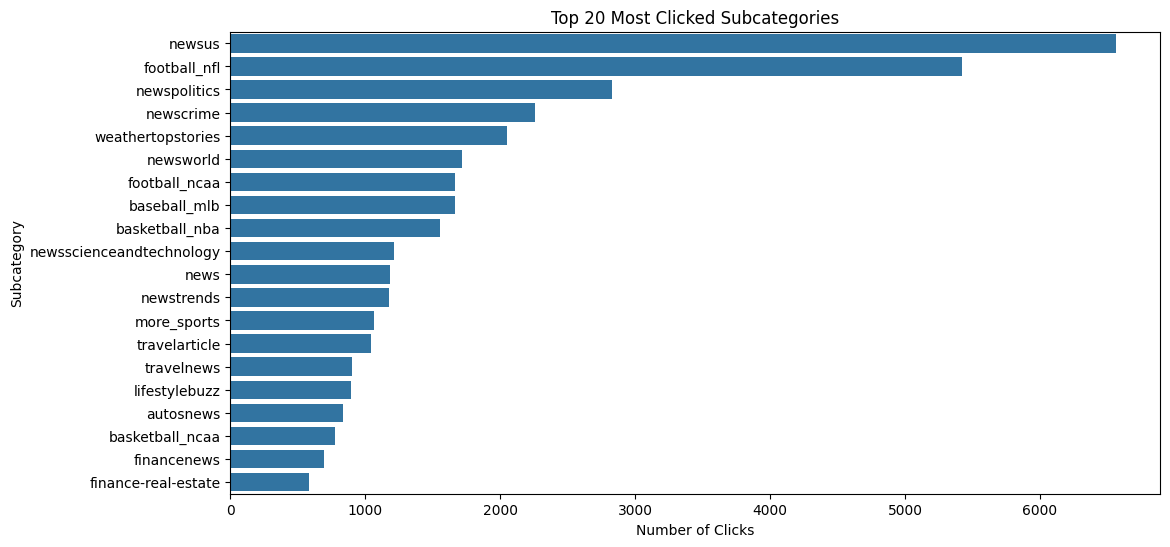

In [13]:
# Most Clicked Subcategories
most_clicked_subcategories = news_data.groupby('subcategory')['newsId'].count().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=most_clicked_subcategories.values, y=most_clicked_subcategories.index)
plt.title('Top 20 Most Clicked Subcategories')
plt.xlabel('Number of Clicks')
plt.ylabel('Subcategory')
plt.show()


Entity Similarity Matrix Shape: (26903, 26903)
Relation Similarity Matrix Shape: (1090, 1090)


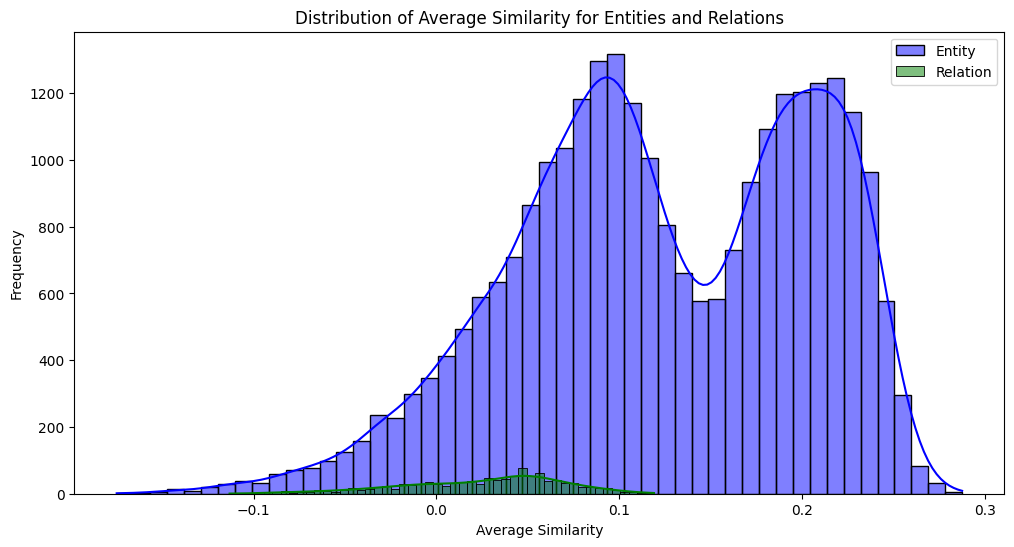

In [14]:
entity_embeddings_matrix = np.array(entity_embedding.iloc[:, 1:].values, dtype=float)
relation_embeddings_matrix = np.array(relation_embedding.iloc[:, 1:].values, dtype=float)

# Filling NaN values with 0
entity_embeddings_matrix = np.nan_to_num(entity_embeddings_matrix)
relation_embeddings_matrix = np.nan_to_num(relation_embeddings_matrix)


# Now you can calculate cosine similarity without encountering the ValueError
entity_similarity = cosine_similarity(entity_embeddings_matrix)
relation_similarity = cosine_similarity(relation_embeddings_matrix)

print("Entity Similarity Matrix Shape:", entity_similarity.shape)
print("Relation Similarity Matrix Shape:", relation_similarity.shape)


# Calculate the average similarity for each entity and relation
entity_avg_similarity = np.mean(entity_similarity, axis=1)
relation_avg_similarity = np.mean(relation_similarity, axis=1)

# Plot the distribution of average similarity for entities and relations
plt.figure(figsize=(12, 6))
sns.histplot(entity_avg_similarity, bins=50, kde=True, color='blue', label='Entity')
sns.histplot(relation_avg_similarity, bins=50, kde=True, color='green', label='Relation')
plt.title('Distribution of Average Similarity for Entities and Relations')
plt.xlabel('Average Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()





## Ring Buffer Test

In [15]:
class RingBuffer:
    def __init__(self, bufsize):
        self.bufsize = bufsize
        self.data = []

    class __Full:
        def add(self, x):
            self.data[self.currpos] = x
            self.currpos = (self.currpos + 1) % self.bufsize

        def get(self):
            return self.data[self.currpos:] + self.data[:self.currpos]

    def add(self, x):
        self.data.append(x)
        if len(self.data) == self.bufsize:
            self.currpos = 0
            self.__class__ = self.__Full

    def get(self):
        return self.data
    
    

In [16]:
buffer_size = 10 # Example buffer size

In [17]:
# Assuming 'behaviors' is your behaviors dataframe
behaviors_buffer = {}

for index, row in behaviors_data.iterrows():
    user_id = row['userId']
    behavior = row.to_dict() # Convert the row to a dictionary for easy storage
    
    if user_id not in behaviors_buffer:
        behaviors_buffer[user_id] = RingBuffer(buffer_size)
    
    behaviors_buffer[user_id].add(behavior)

In [18]:
# Example: Get the most recent behaviors for a specific user
user_id = 'U13740' # Example user ID
user_behaviors = behaviors_buffer[user_id].get()
print(user_behaviors)

[{'impressionId': 1, 'userId': 'U13740', 'timestamp': Timestamp('2019-11-11 09:05:58'), 'click_history': 'N55189 N42782 N34694 N45794 N18445 N63302 N10414 N19347 N31801', 'impressions': 'N55689-1 N35729-0', 'clicks': 9.0, 'impressions_list': ['N55689-1', 'N35729-0'], 'impressions_count': 2}, {'impressionId': 35263, 'userId': 'U13740', 'timestamp': Timestamp('2019-11-09 05:59:43'), 'click_history': 'N55189 N42782 N34694 N45794 N18445 N63302 N10414 N19347 N31801', 'impressions': 'N20020-0 N3737-0 N43202-0 N18708-0 N30125-0 N349-0 N43388-0 N32260-0 N3491-0 N57972-0 N43370-0 N31602-0 N7128-0 N43001-0 N10359-0 N22600-0 N10602-0 N5889-0 N17650-0 N59761-0 N7891-0 N31025-0 N49879-0 N31748-0 N59457-0 N60374-0 N38330-0 N46567-0 N33291-0 N58075-0 N52649-0 N54300-0 N39707-0 N1080-0 N21428-0 N15361-0 N59931-0 N41400-0 N39115-0 N59893-0 N14522-0 N3449-0 N28091-0 N5442-0 N63835-0 N20147-0 N23060-0 N19099-0 N39587-0 N14884-0 N29749-0 N33981-0 N17087-0 N62647-0 N9019-0 N53343-0 N64228-0 N41615-0 N52875